Topic: 
**Electric Vehicle State of Charge Increase and Seasonality Hypothesis Testing**

**Dataset**:
https://www.kaggle.com/datasets/michaelbryantds/electric-vehicle-charging-dataset

**Approach**
Using this data set, we will attempt to determine if there is a correlation between seasonality and the percentage charging performed.

To do this we will perform a hypothesis test on the following null and alternative hypotheses:

Ho (Null Hypothesis): The average charge energy per day has no correlation with the season.

Ha (Alternative Hypothesis): The average charge energy per day is correlated with the season.

Performing this hypothesis test will provide information about consumer behavior, and may assist EV charging outlets and electric utilities in tailoring their services to meet consumer demand.

**Seasons will be defined as follows**:

●	Spring - March 1 - May 31

●	Summer - June 1 - August 31

●	Fall - September 1 - November 30

●	Winter - December 1 - February 28 (29th if a leap year)


**Supplementary Information**
https://www.nature.com/articles/s41597-021-00956-1
https://www.energy.gov/sites/prod/files/2017/01/f34/WPCC_2016%20Annual%20Progress%20Report.pdf


**Group members**:
* Andrew, Ewing, aewing
* Katrina, Smallacombe, ksmallac
* Nav, Dhillon, ndhillon
* Simran, Bilkhu, sbilkhu
* Talal, Kanaan, tkanaan
* Xiaohong, Lu, x46lu

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import random
import math
#from math import sqrt
import statsmodels.formula.api as sm
import statsmodels.api as sm
from statsmodels.api import OLS
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import seaborn as sns
%matplotlib inline
#from sklearn.model_selection import train_test_split
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.linear_model import LinearRegression
#from sklearn.metrics import accuracy_score
#from sklearn.preprocessing import StandardScaler

In [2]:
from google.colab import files
uploaded = files.upload()

Saving station_data_dataverse.csv to station_data_dataverse.csv


In [3]:
df = pd.read_csv("station_data_dataverse.csv")

In [4]:
df.head(5)

,sessionId,kwhTotal,dollars,created,ended,startTime,endTime,chargeTimeHrs,weekday,platform,...,managerVehicle,facilityType,Mon,Tues,Wed,Thurs,Fri,Sat,Sun,reportedZip
0,1366563,7.78,0.00,0014-11-18 15:40:26,0014-11-18 17:11:04,15,17,1.510556,Tue,android,...,0,3,0,1,0,0,0,0,0,0
1,3075723,9.74,0.00,0014-11-19 17:40:26,0014-11-19 19:51:04,17,19,2.177222,Wed,android,...,0,3,0,0,1,0,0,0,0,0
2,4228788,6.76,0.58,0014-11-21 12:05:46,0014-11-21 16:46:04,12,16,4.671667,Fri,android,...,0,3,0,0,0,0,1,0,0,0
3,3173284,6.17,0.00,0014-12-03 19:16:12,0014-12-03 21:02:18,19,21,1.768333,Wed,android,...,0,3,0,0,1,0,0,0,0,0
4,3266500,0.93,0.00,0014-12-11 20:56:11,0014-12-11 21:14:06,20,21,0.298611,Thu,android,...,0,3,0,0,0,1,0,0,0,0


In [5]:
#how complete is the data set?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3395 entries, 0 to 3394
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sessionId       3395 non-null   int64  
 1   kwhTotal        3395 non-null   float64
 2   dollars         3395 non-null   float64
 3   created         3395 non-null   object 
 4   ended           3395 non-null   object 
 5   startTime       3395 non-null   int64  
 6   endTime         3395 non-null   int64  
 7   chargeTimeHrs   3395 non-null   float64
 8   weekday         3395 non-null   object 
 9   platform        3395 non-null   object 
 10  distance        2330 non-null   float64
 11  userId          3395 non-null   int64  
 12  stationId       3395 non-null   int64  
 13  locationId      3395 non-null   int64  
 14  managerVehicle  3395 non-null   int64  
 15  facilityType    3395 non-null   int64  
 16  Mon             3395 non-null   int64  
 17  Tues            3395 non-null   i

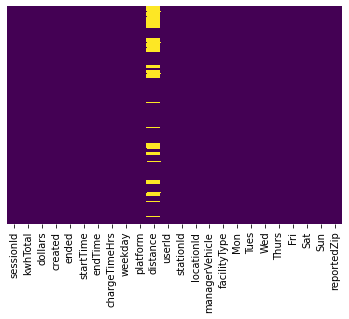

In [6]:
#visualize if there is any missing data
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Distance is the only data point with missing values.  According to the study details, https://github.com/asensio-lab/workplace-charging-experiment/, distance is the distance from a user's home to the charging location, expressed in miles except where user did not report address.
We do not feel like this data point is relevant to this analysis.

In [7]:
#add a year and month column
#cleansing the dates:
#(pandas timestamp use milliseconds so it cannot hold more than 540 years or so. In the dataset year 
# is considered as 14 for 2014 e.g., while the conversion assume it is year 14 in the first century)
#Talal note: this regex might introduce value error, we need to review the reg expression (e.g., we need to replace the first occurrance only)
df['created'] = df['created'].str.replace(r"00",  "20", regex=True)
df['ended'] = df['ended'].str.replace(r"00",  "20", regex=True)

#creating the years and months columns depending on creation date only (is this enough ? Could a charge session start in a day and end in the next day (next month ? next season ?) We might neglect this.
df['year'] = pd.DatetimeIndex(df['created']).year
df['month'] = pd.DatetimeIndex(df['created']).month

#add the season column
#creating the season column depending on the creation date
df['season'] = np.where((df['month'] >= 3) & (df['month'] <= 5), 'Spring', 'Winter')
df['season'] = np.where((df['month'] >= 6) & (df['month'] <= 8), 'Summer', df['season'])
df['season'] = np.where((df['month'] >= 9) & (df['month'] <= 11), 'Fall', df['season'])



In [8]:
df

,sessionId,kwhTotal,dollars,created,ended,startTime,endTime,chargeTimeHrs,weekday,platform,...,Tues,Wed,Thurs,Fri,Sat,Sun,reportedZip,year,month,season
0,1366563,7.78,0.00,2014-11-18 15:40:26,2014-11-18 17:11:04,15,17,1.510556,Tue,android,...,1,0,0,0,0,0,0,2014,11,Fall
1,3075723,9.74,0.00,2014-11-19 17:40:26,2014-11-19 19:51:04,17,19,2.177222,Wed,android,...,0,1,0,0,0,0,0,2014,11,Fall
2,4228788,6.76,0.58,2014-11-21 12:05:46,2014-11-21 16:46:04,12,16,4.671667,Fri,android,...,0,0,0,1,0,0,0,2014,11,Fall
3,3173284,6.17,0.00,2014-12-03 19:16:12,2014-12-03 21:02:18,19,21,1.768333,Wed,android,...,0,1,0,0,0,0,0,2014,12,Winter
4,3266500,0.93,0.00,2014-12-11 20:56:11,2014-12-11 21:14:06,20,21,0.298611,Thu,android,...,0,0,1,0,0,0,0,2014,12,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3390,7021565,6.74,0.00,2015-10-01 16:31:18,2015-10-01 19:59:08,16,19,3.463889,Thu,ios,...,0,0,1,0,0,0,1,2015,10,Fall
3391,3758092,6.86,0.00,2015-10-02 16:28:48,2015-10-02 19:27:05,16,19,2.971389,Fri,ios,...,0,0,0,1,0,0,1,2015,10,Fall
3392,5858374,6.07,0.00,2015-09-30 16:54:22,2015-09-30 20:24:06,16,20,3.495556,Wed,android,...,0,1,0,0,0,0,1,2015,9,Fall
3393,2586645,5.74,0.00,2015-09-24 11:43:02,2015-09-24 13:55:12,11,13,2.202778,Thu,ios,...,0,0,1,0,0,0,1,2015,9,Fall


In [9]:
# Looking to see if there are individual stations which exhibit more seasonal behaviour than others, this could show us which stations are in locations with higher temperature variance between seasons.
individual_stations = df.groupby(['stationId', 'season']).agg({'kwhTotal': ['mean']})
individual_stations=individual_stations.reset_index()

In [10]:
individual_stations


,stationId,season,kwhTotal
,,,mean
0,129465,Fall,5.823333
1,129465,Spring,4.600000
2,129465,Summer,6.405882
3,129465,Winter,4.417500
4,131897,Fall,4.730000
...,...,...,...
280,989457,Fall,6.640000
281,989457,Summer,5.480000
282,989457,Winter,3.070000


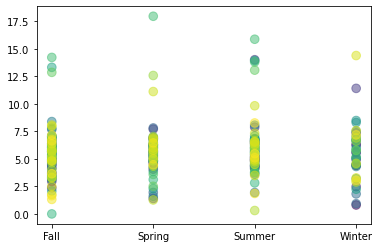

In [11]:
#visualizing kWh totals by season per station
x=np.array(individual_stations.season)
y=np.array(individual_stations.kwhTotal)
colors=individual_stations.stationId
plt.scatter(x[:], y, c=colors, alpha=0.5, s=75)
plt.show()

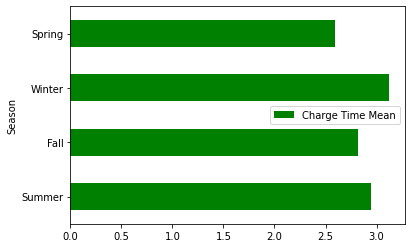

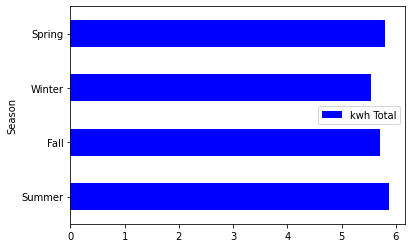

In [12]:
#Plots to analyze data based on season
seasons = ['Summer', 'Fall', 'Winter', 'Spring']
dfTimeMean = pd.DataFrame({'Season': seasons,
                   'Charge Time Mean': [df.loc[df['season'] == 'Summer', 'chargeTimeHrs'].mean(), 
                                    df.loc[df['season'] == 'Fall', 'chargeTimeHrs'].mean(), 
                                    df.loc[df['season'] == 'Winter', 'chargeTimeHrs'].mean(), 
                                    df.loc[df['season'] == 'Spring', 'chargeTimeHrs'].mean()]})
dfTimeMean.plot(x='Season', y='Charge Time Mean', kind='barh', color='g')

dfkwh = pd.DataFrame({'Season': seasons,
                   'kwh Total': [df.loc[df['season'] == 'Summer', 'kwhTotal'].mean(), 
                                    df.loc[df['season'] == 'Fall', 'kwhTotal'].mean(), 
                                    df.loc[df['season'] == 'Winter', 'kwhTotal'].mean(), 
                                    df.loc[df['season'] == 'Spring', 'kwhTotal'].mean()]})
dfkwh.plot(x='Season', y='kwh Total', kind='barh', color='b')
plt.show()


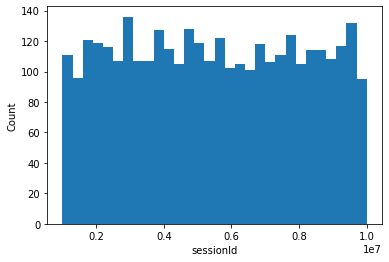

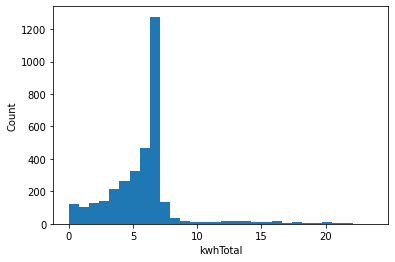

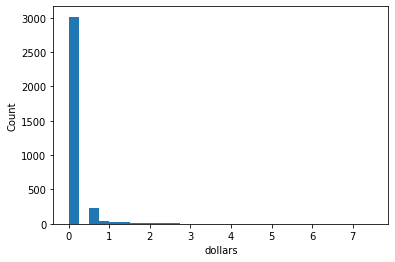

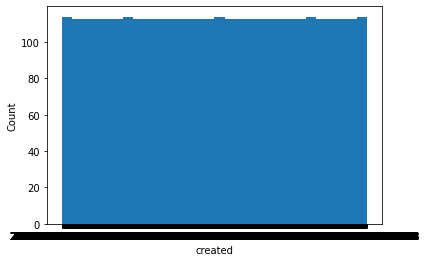

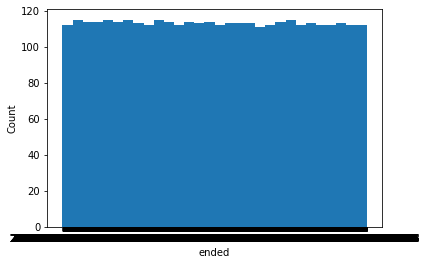

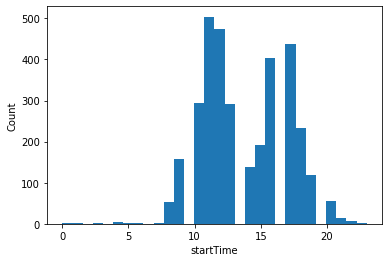

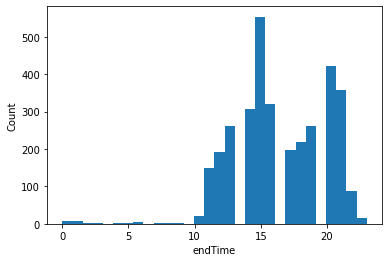

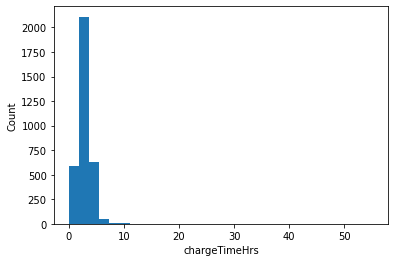

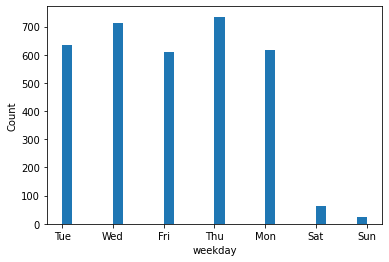

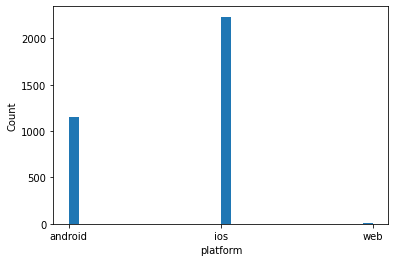

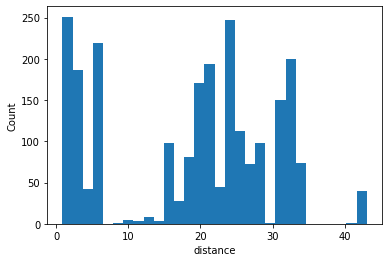

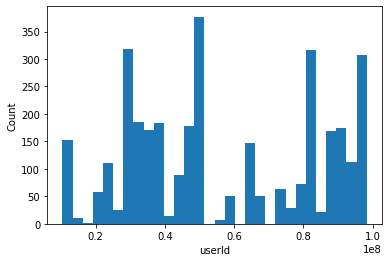

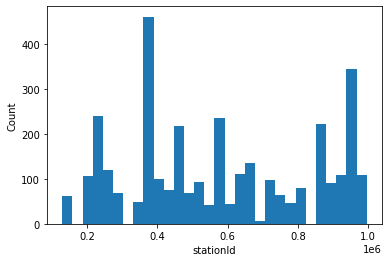

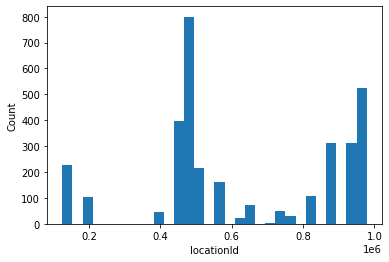

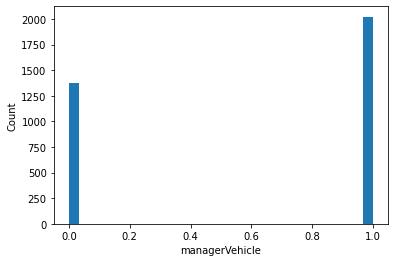

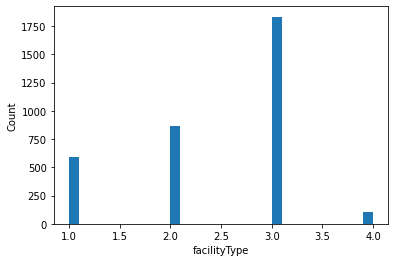

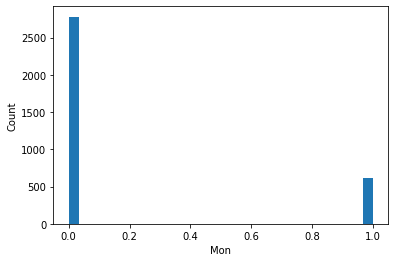

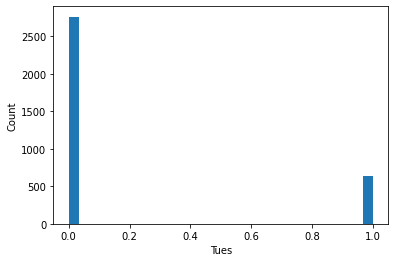

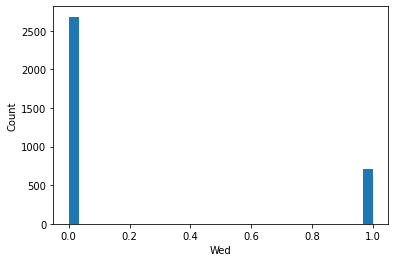

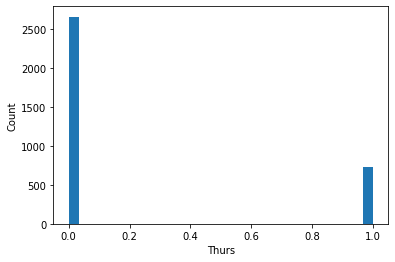

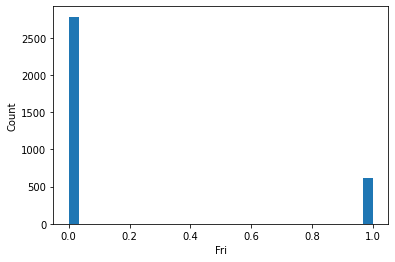

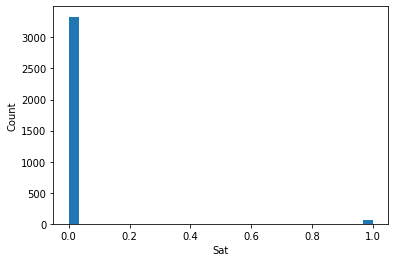

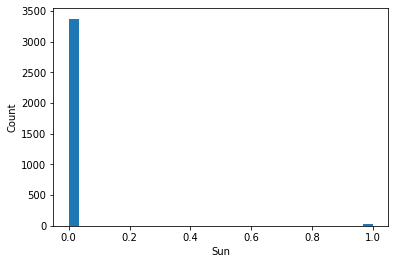

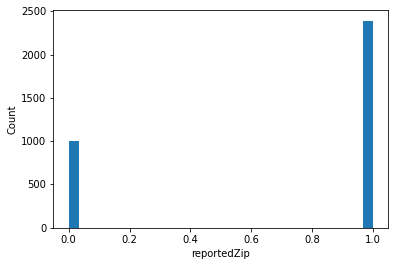

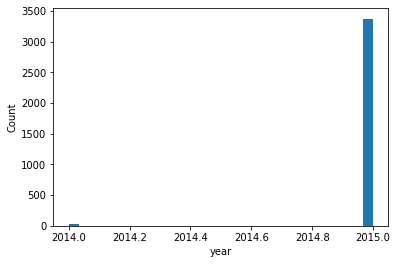

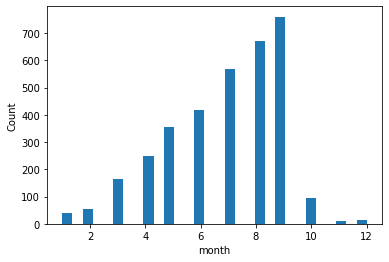

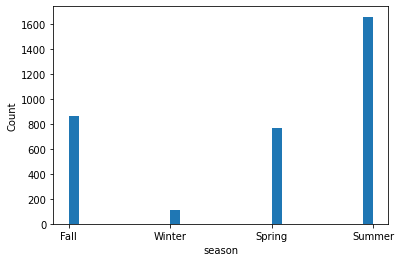

In [13]:
#plot histograms of our data to see if we can spot any outliers
for col in df.columns:
    plt.hist(df[col],bins=30)
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

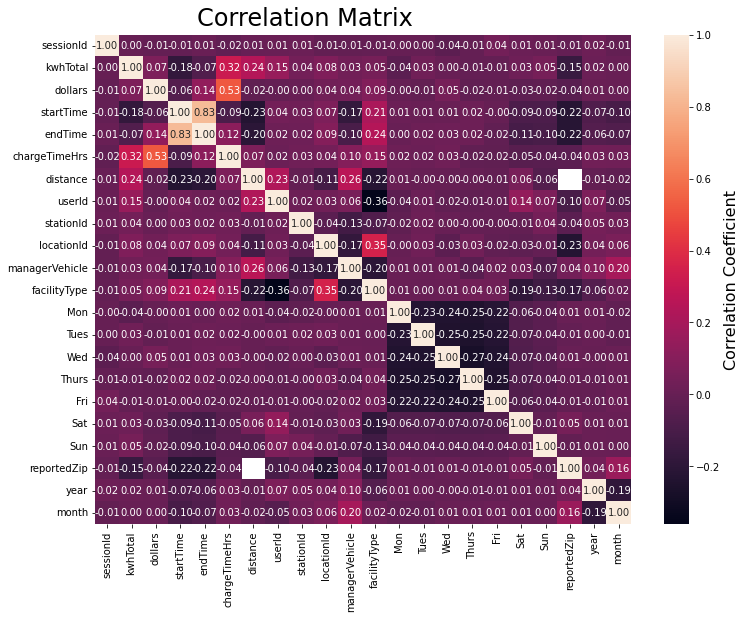

In [14]:
covMatrix = pd.DataFrame.corr(df)
plt.figure(figsize=(12,9))
ax=sns.heatmap(covMatrix, annot=True, fmt='.2f', cbar_kws={'label': 'Correlation Coefficient'})
ax.figure.axes[-1].yaxis.label.set_size(16)
title = 'Correlation Matrix'
plt.text(4.2,-0.4,title, fontsize=24)
plt.show()

Above we can see the correlation between different variables. A correlation coefficient tells you the relationship between two variables. A positive value means that as one variable increases, so does the other, and a negative value means that as one variable increases the other decreases.

We can look at the results for the dependant variable, charging energy. We see that most variables we consider have small degrees of positive correlations with charge energy (kWh Total). The strongest relationship exists between charging energy and charging time, which is expected as charging for a longer time is highly likely to increase the amount of kWh charged..

Below we plot the scatterplots of the variables above to visualize the correlations.

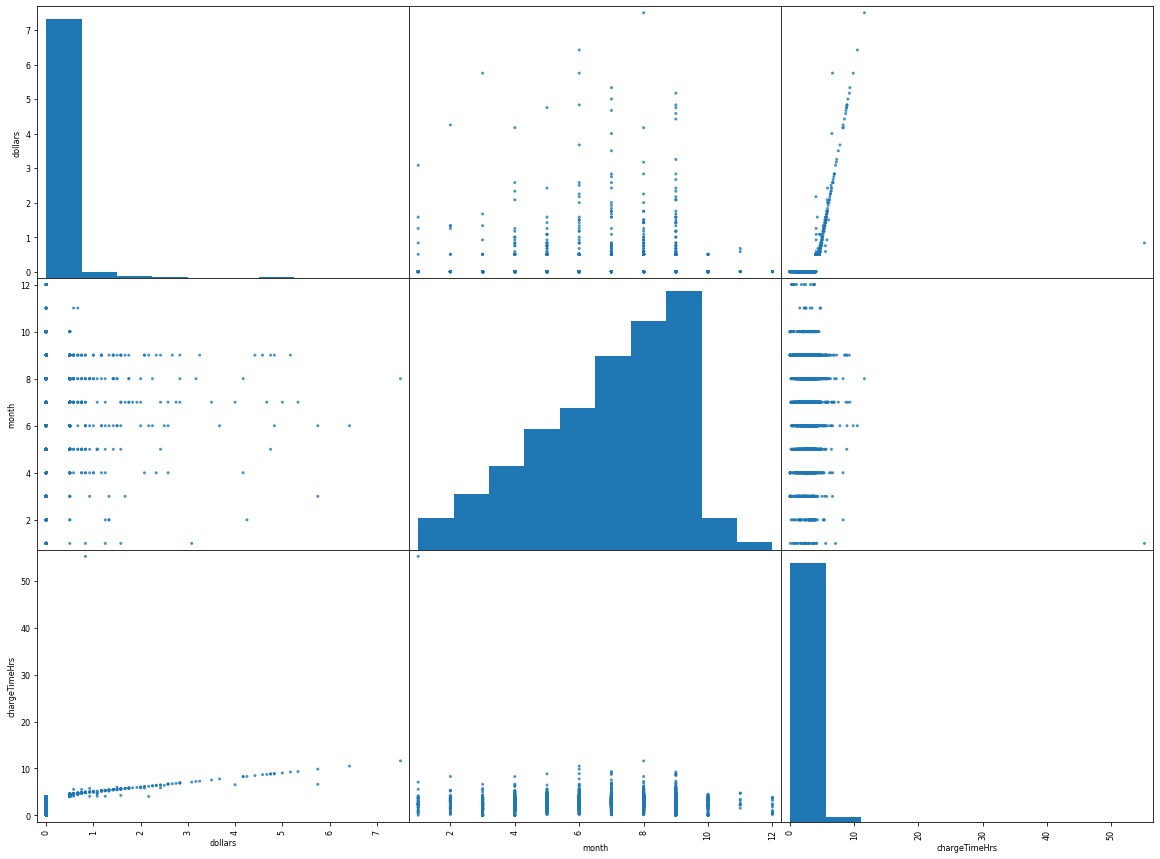

In [15]:
plt.rcParams.update({'font.size': 8}) 
pd.plotting.scatter_matrix(df[['season','dollars','weekday','month','chargeTimeHrs',]],figsize=(20,15),alpha=0.8)
plt.show()

In [16]:
#Talal: This should be the correct model
mymap = {'Spring':1, 'Summer':2, 'Fall':3, 'Winter':4}
dfmapped = df.applymap(lambda s: mymap.get(s) if s in mymap else s)

dfmapped.drop(['dollars', 'created', 'ended',  'startTime', 'endTime','chargeTimeHrs', 
'weekday', 'platform', 'distance', 'userId', 'stationId', 'locationId','managerVehicle',
'facilityType', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 'reportedZip',  
'year', 'month'] , axis=1, inplace=True)

model1 = sm.OLS(dfmapped.kwhTotal, dfmapped.season)
res1 = model1.fit()
print(res1.summary())


                                 OLS Regression Results                                
Dep. Variable:               kwhTotal   R-squared (uncentered):                   0.700
Model:                            OLS   Adj. R-squared (uncentered):              0.700
Method:                 Least Squares   F-statistic:                              7926.
Date:                Mon, 12 Dec 2022   Prob (F-statistic):                        0.00
Time:                        17:04:44   Log-Likelihood:                         -9122.0
No. Observations:                3395   AIC:                                  1.825e+04
Df Residuals:                    3394   BIC:                                  1.825e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [17]:
#Talal: Let's do some transformation and check the model

#trying the sqrt
dfsqrt=np.sqrt(dfmapped)
dfsqrt1 = dfsqrt.copy() 
#sqrt for kwh only
dfsqrt1["season"] = dfmapped["season"]
dfsqrt1["sessionId"] = dfmapped["sessionId"]

model2 = sm.OLS(dfsqrt1.kwhTotal, dfsqrt1.season)
res2 = model2.fit()
print(res2.summary())

                                 OLS Regression Results                                
Dep. Variable:               kwhTotal   R-squared (uncentered):                   0.811
Model:                            OLS   Adj. R-squared (uncentered):              0.811
Method:                 Least Squares   F-statistic:                          1.452e+04
Date:                Mon, 12 Dec 2022   Prob (F-statistic):                        0.00
Time:                        17:04:44   Log-Likelihood:                         -4979.9
No. Observations:                3395   AIC:                                      9962.
Df Residuals:                    3394   BIC:                                      9968.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [18]:
#trying the exp
dfexp=np.exp(dfmapped)
dfexp1 = dfexp.copy() 
#exp for kwh only
dfexp1["season"] = dfmapped["season"]
dfexp1["sessionId"] = dfmapped["sessionId"]

model3 = sm.OLS(dfexp1.kwhTotal, dfexp1.season)
res3 = model3.fit()
print(res3.summary())
#drop it from the experiment, R2 is only 0.002 !

#trying the log
dflog=np.log(dfmapped)
dflog1 = dflog.copy() 
#exp for kwh only
dflog1["season"] = dfmapped["season"]
dflog1["sessionId"] = dfmapped["sessionId"]

model4 = sm.OLS(dflog1.kwhTotal, dflog1.season)
res4 = model4.fit()
print(res4.summary())

#drop it from the experiment!

                                 OLS Regression Results                                
Dep. Variable:               kwhTotal   R-squared (uncentered):                   0.002
Model:                            OLS   Adj. R-squared (uncentered):              0.002
Method:                 Least Squares   F-statistic:                              6.710
Date:                Mon, 12 Dec 2022   Prob (F-statistic):                     0.00963
Time:                        17:04:44   Log-Likelihood:                         -71665.
No. Observations:                3395   AIC:                                  1.433e+05
Df Residuals:                    3394   BIC:                                  1.433e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/usr/local/lib/python3.8/dist-packages/statsmodels/regression/linear_model.py:1631: RuntimeWarning: invalid value encountered in subtract
  return self.model.wendog - self.model.predict(
/usr/local/lib/python3.8/dist-packages/statsmodels/regression/linear_model.py:897: RuntimeWarning: invalid value encountered in subtract
  resid = self.endog - np.dot(self.exog, params)
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:1292: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


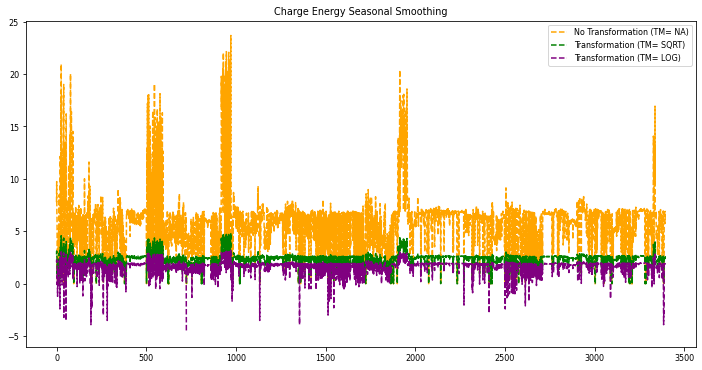

In [19]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(dfmapped.index, dfmapped.kwhTotal, linestyle='--', color='orange', label="No Transformation (TM= NA)");
ax.plot(dfsqrt1.index, dfsqrt1.kwhTotal, linestyle='--', color='green', label="Transformation (TM= SQRT)"); 
#ax.plot(dfexp1.index, dfexp1.kwhTotal, linestyle='--', color='red', label="Transformation (TM= EXP)"); 
ax.plot(dflog1.index, dflog1.kwhTotal, linestyle='--', color='purple', label="Transformation (TM= LOG)"); 

ax.legend();
ax.set_title("Charge Energy Seasonal Smoothing");